In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
if 'thesis.Aircraft' in sys.modules: del sys.modules['thesis.Aircraft']
from thesis.ThesisCraft import craft

if 'thesis.EvalHelper' in sys.modules: del sys.modules['thesis.EvalHelper']
if 'thesis.Scenario' in sys.modules: del sys.modules['thesis.Scenario']
plt.rcParams.update({'font.size':16})

from thesis.EvalHelper import Judge
from thesis.Scenario import Scenario

scene = Scenario()
import random
random.seed(0)
#scene.addRandomGroundUsersUniformCircular(5, r = 5000)
for x in range(-2000, 2001, 500):
    for y in range(-2000, 2001, 500):
        if random.random() < 0.25:
          scene.addUser(vector((x, y, 0)))

judge = Judge(scene, craft)

%load_ext snakeviz
scene.render(size=50000)


Mass is 85.85 kg (50.16 kg struct, 15.50 kg bat)


Graphics3d Object

In [2]:
def MakePlotUpdater(iters):
  fig, ax = plt.subplots(2, figsize=(8,10))
  ax[0].set_ylim(-50, 50)
  ax[1].set_xlim(0, iters)
  highest = 0
  lowest = 999
  
  curves = []
  
  def update(i, scores, best):
    # Fade out old curves
    for curve in curves:
      curve.set_alpha(curve.get_alpha() * 0.9)
    
    curves.append(ax[0].plot(scores, alpha=1)[0])
    nonlocal highest, lowest
    highest = max(highest, scores.max())
    if scores.max() > 0:
      lowest = min(lowest, scores.max())
    ax[0].set_ylim(lowest-1, highest+1)
    ax[1].set_ylim(lowest-1, highest+1)
    fig.canvas.draw()
    
    ax[1].scatter([i], [scores.mean()], s=1, color='green')
    
    ax[1].scatter([i], [scores.max()], s=1)
    ax[1].scatter([i], [best], color='red', s=1)
  return update

In [3]:
# Particle Swarm Optimization
from tqdm.auto import tqdm

if 'thesis.optimize.functions' in sys.modules: del sys.modules['thesis.optimize.functions']
from thesis.optimize.functions import (
  SplineyFitnessHelper, batteryReward, throughputReward, throughputPenalty,
  energyPenalty, gravityReward, radiusPenalty, altitudePenalty, energyPenalty,
  speedPenalty, thrustPenalty
)
times = pd.date_range(start = '2020-11-28T08', end = '2020-11-28T09', freq='10S', tz='America/Detroit').to_series()

if 'thesis.optimize.BaseOptimizer' in sys.modules: del sys.modules['thesis.optimize.BaseOptimizer']
if 'thesis.optimize.PSOv2' in sys.modules: del sys.modules['thesis.optimize.PSOv2']
from thesis.optimize.PSOv2 import PSO

numParticles = 30
numPoints = 4
numWaypoints = numPoints * 4
numCodons = numWaypoints * 6

m = 1800 / math.sqrt(2)

template = [
#   1500, 480, 1000, 0, 5, 5,
#   1500.5, -480.5, 1000, pi, 5, 5,
#   -1500, 480, 1000, pi, 5, 5,
#   -1500.5, -480.5, 1000, 0,  5, 5,
    0, 1800.1, 1000, 0, 5, 5,
    #m, m, 1000, 7*pi/4, 5, 5,
    1800, 0.1, 1000, 3*pi/2, 5, 5,
    #m, -m, 1000, 5*pi/4, 5, 5,
    0, -1800.1, 1000, pi, 5, 5,
    #-m, -m, 1000, 3*pi/4, 5, 5,
    -1800, 0.1, 1000, pi / 2, 5, 5,
    #-m, m, 1000, 1*pi/4, 5, 5,
] * numPoints
offsets = [5, 5, -40, 0.05, 0.25, 0.25]

bounds = [
  (-1500, 1500),
  (-1500, 1500),
  (1000, 10000),
  (None, None), # TODO make a proper distance formula for direction
  (0, 12),
  (0, 12),
]

#zOffsets = np.random.uniform(-20, 20, numPoints)
zOffsets = np.full(numWaypoints, 0.0L)
# Just things (bias initial particles up then down)
z0, z1 = 1000, 1000
perStep = (z1 - z0) / numWaypoints
print('going up', perStep)
zOffsets[:] += perStep
template[2::6] = zOffsets.cumsum() + z0

def createParticle(i):
    if i == 0:
      return template
  
    # This is kinda silly
    np.random.seed(random.randint(0,99999999))
    at = template.copy()
    for i in range(len(template)):
      off = offsets[i % len(offsets)]
      at[i] += np.random.uniform(off / 2, off * 2)
    return at
  
helper = SplineyFitnessHelper(judge, craft, times, expr = [
  #batteryReward(),
  #gravityReward() * 0.5L,
  radiusPenalty(2000) * 1e-6L,
  altitudePenalty(1000, 10000),
  throughputReward() / 1e6L / len(scene.users),
  # Here is where we would put our budget
  energyPenalty(600, gravityCoeff = 0.5),
  thrustPenalty(hi = 100),
  speedPenalty(lo = 6, hi = 25)
], desiredDuration = 3600, initialPosition = [0, 1800.1, 1000, 0])

traj, alphas = helper.getTrajBuilder()(createParticle(0))
(traj.render() + scene.render(size=55555)).show()
print(helper.getFitness(debug=True)(createParticle(1)))
print(traj.scale)

going up 0


Graphics3d Object

((((((RP<-0.0>*1e-06)+AP<-781865.8852735007>)+((TR<339273649.6271924>/1000000.0)/11))+EP<0>)+TRP<-0.0>)+VP<-0.0>)
0.7861529618961459


For 2020-11-28 08:00:00 gained 125.25897696573611
For 2020-11-28 09:00:00 gained 828.0570157734855
For 2020-11-28 10:00:00 gained 1397.8296514818494
For 2020-11-28 11:00:00 gained 1749.546306333319
For 2020-11-28 12:00:00 gained 1849.572283627229
For 2020-11-28 13:00:00 gained 1690.4598611677056
For 2020-11-28 14:00:00 gained 1285.6206254539293
For 2020-11-28 15:00:00 gained 678.2810629317555
For 2020-11-28 16:00:00 gained -21.33771611688553
For 2020-11-28 17:00:00 gained -377.1823855916946
For 2020-11-28 18:00:00 gained -384.3193922675573
For 2020-11-28 19:00:00 gained -384.3193922675573
For 2020-11-28 20:00:00 gained -384.3193922675573
For 2020-11-28 21:00:00 gained -384.3193922675573
For 2020-11-28 22:00:00 gained -384.3193922675573
For 2020-11-28 23:00:00 gained -384.3193922675573
For 2020-11-29 00:00:00 gained -384.3193922675573
For 2020-11-29 01:00:00 gained -384.3193922675573
For 2020-11-29 02:00:00 gained -384.3193922675573
For 2020-11-29 03:00:00 gained -384.3193922675573
For 

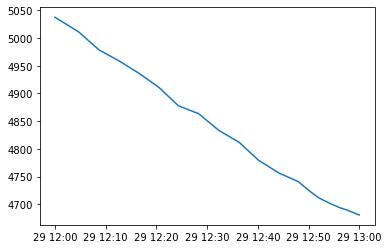

In [13]:
from thesis.Flight import Flight
vec = createParticle(1)
helper.getTrajBuilder()(vec)[0].render()

start = pd.to_datetime('2020-11-28T07')
hr = pd.to_timedelta('1h')
data = []
for i in range(24):
  start += hr
  
  
  times = pd.date_range(start = start, end = start+hr, freq='10S', tz='America/Detroit').to_series()
  

  traj, alphas = helper.getTrajBuilder()(vec)
  flight = Flight(craft, traj, alphas)
  stats = judge.flightStats(flight, times=times)
  bat = stats['battery']


  %matplotlib inline
  fig, ax = plt.subplots()
  ax.plot(bat)
  delta = bat[bat.index[-1]] - bat[bat.index[0]]
  print('For', start, 'gained', delta)
  data.append(delta)
  
print('Total is', sum(data))

In [61]:
from thesis.Flight import Flight
traj, alphas = helper.getTrajBuilder()(swarm.best[0])
flight = Flight(craft, traj, alphas)
stats = judge.flightStats(flight)
bat = stats['battery']

bat['20201128T1000'] - bat['20201128T0900']

587.3448153141035

starting
Generated initial 30 particles


<IPython.core.display.Javascript object>


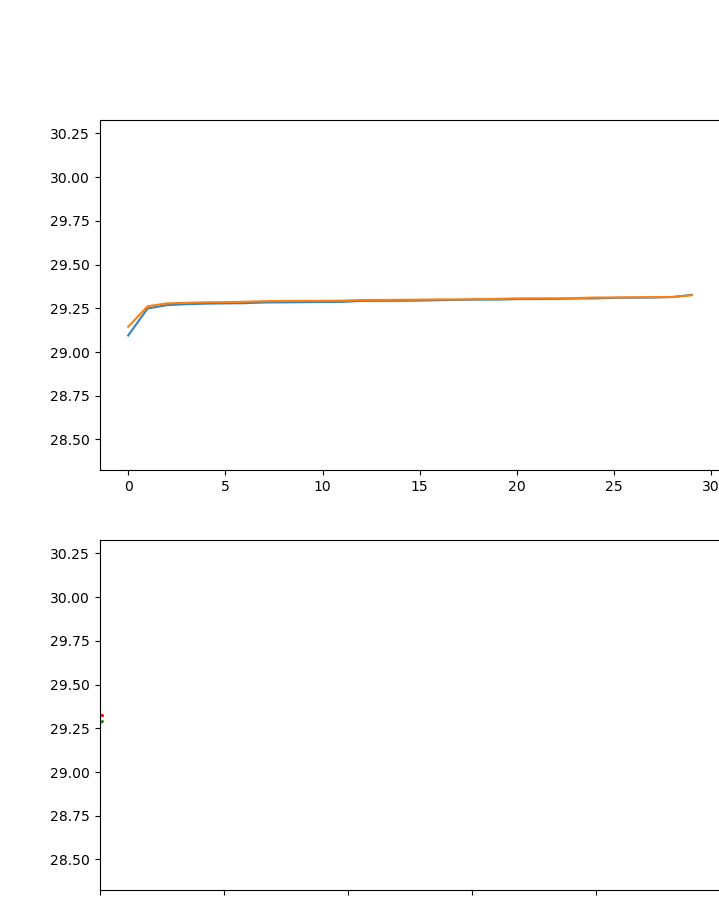

iter=0	low score=29.09	high score=29.33/29.33	vel~0.00-252.54
iter=1	low score=29.14	high score=29.33/29.33	vel~103.61-504.08



KeyboardInterrupt: 

In [7]:

  
def wRamp(it):
  from math import sqrt
  return 0.99 / (1 + sqrt(it) / 500)
  
# 0.99 gave reasonable results, but had a lot of fast particles still...
# Probably we are supposed to bound our space?
swarm = PSO(numParticles, numCodons, createParticle, helper.getFitness(), processes=30, wSchedule = wRamp, bounds=bounds)

data = []

%matplotlib notebook
upd = MakePlotUpdater(250)

def onIteration(i):
    pt = [vw[2] for vw in swarm.particles]
    scores = np.array(pt)
    vels = np.array([vw[1].length() for vw in swarm.particles])
    
    print('iter=%d\tlow score=%.2f\thigh score=%.2f/%.2f\tvel~%.2f-%.2f' % (
      i,
      scores.min(),
      scores.max(),
      swarm.best[1],
      vels.min(),
      vels.max()
    ))
    
    pt = [
      (
        round(particle[2], 2), 
        round(particle[1].length())
      ) 
      for particle 
      in swarm.particles
    ]
    data.append(pt)
    
    upd(i, scores, swarm.best[1])
    

swarm.iterateMany(iterations = tqdm(range(250)), cb=onIteration)
# vecToTrajectory = helper.getTrajBuilder()
# vec=createParticle(0)
# vecToTrajectory(vec)[0].render().show()
# helper.getFitness(vecToTrajectory, debug=True)(vec)

In [6]:
print(helper.getFitness(debug=True)(swarm.best[0]))
helper.getTrajBuilder()(swarm.best[0])[0].render()

traj, alphas = helper.getTrajBuilder()(swarm.best[0])
sum([
  traj.render(),
  scene.render(size=55555),
  plot3d(1000, (var('x'),-2000,2000),(var('y'),-2000,2000), alpha=0.2, color='red'),
  plot3d(2000, (var('x'),-2000,2000),(var('y'),-2000,2000), alpha=0.2, color='red'),
]).show()
print('scale', traj.scale)
stats = judge.flightStats(flight, times=times)
bat = stats['battery']

#bat['20201128T1000'] - bat['20201128T0900']
bat[bat.index[-1]] - bat[bat.index[0]]

NameError: name 'swarm' is not defined

In [16]:
vec, flight, score, waypoint, charge, stats = optimizePiece('2020-11-28T07', '2020-11-28T08', 0.5*15.5*650, [0, 1800, 1000, 0, 5, 5], 0)

ZeroDivisionError: float division by zero

going up 62.5
starting
Generated initial 30 particles


<IPython.core.display.Javascript object>


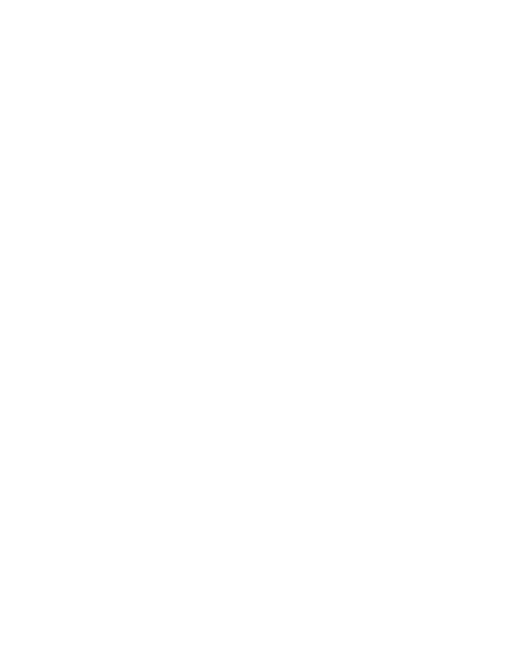

iter=0	low score=18.41	high score=22.01/22.01	vel~0.00-256.74
iter=1	low score=19.18	high score=22.01/22.01	vel~0.00-436.12
iter=2	low score=20.32	high score=22.03/22.03	vel~64.40-574.73
iter=3	low score=21.49	high score=22.21/22.21	vel~118.81-658.15
iter=4	low score=21.85	high score=22.80/22.80	vel~107.41-650.22
iter=5	low score=22.11	high score=23.87/23.87	vel~149.64-643.72
iter=6	low score=-19957.51	high score=24.81/24.81	vel~155.10-586.76
iter=7	low score=-20955.85	high score=25.65/25.65	vel~235.65-580.89
iter=8	low score=-40935.22	high score=26.39/26.39	vel~409.05-575.08
iter=9	low score=-41933.27	high score=27.04/27.04	vel~484.82-744.80
iter=10	low score=-61912.13	high score=26.52/27.04	vel~548.90-888.68
iter=11	low score=-83889.25	high score=27.43/27.43	vel~429.36-947.70
iter=12	low score=-61910.85	high score=27.19/27.43	vel~276.62-843.46
iter=13	low score=-61909.81	high score=27.49/27.49	vel~208.25-684.33
iter=14	low score=-61910.33	high score=27.94/27.94	vel~220.73-605.55
iter

<IPython.core.display.Javascript object>


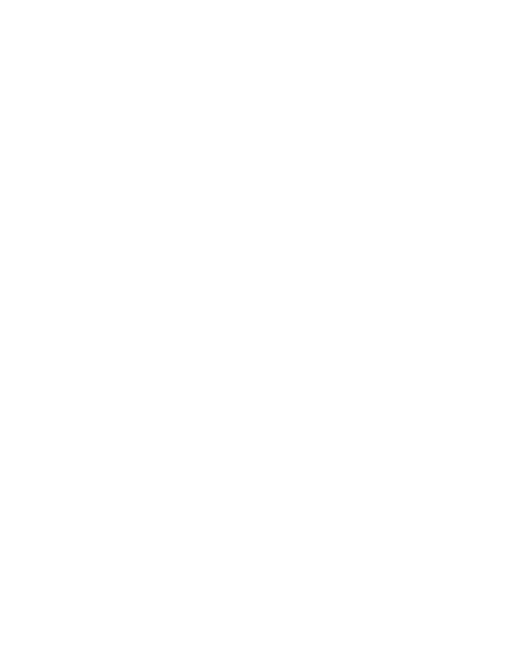

In [29]:
#vec[5::6]
vec2, flight2, score2, waypoint2, charge2, stats2 = optimizePiece('2020-11-28T10', '2020-11-28T11', charge, waypoint, 600)
#%matplotlib inline
#stats['poses'].power.plot()
#stats['solar'].plot()

In [30]:
from thesis.optimize.functions import Defunc
helper = SplineyFitnessHelper(
    judge, craft, times,
    expr = Defunc(1),
    desiredDuration = 3600,
    initialPosition = [0, 1800, 1000, 0, 5, 5]
  )

traj, alphas = helper.getTrajBuilder()(vec)

helper = SplineyFitnessHelper(
    judge, craft, times,
    expr = Defunc(1),
    desiredDuration = 3600,
    initialPosition = waypoint
  )
traj2, alphas = helper.getTrajBuilder()(vec2)
(traj.render() + traj2.render(color='red'))


Graphics3d Object

In [4]:
from thesis.optimize.ParallelNelderMead import ParallelNelderMead
from thesis.optimize.PSOv2 import PSO

def optimizePiece(time_start, time_end, charge_start, initial_waypoint, budget, mode = 'pso', its=50):
  from thesis.Flight import Flight
  from math import pi
  
  bat_cap = 15.5 * 650
  charge_start_ratio = charge_start / bat_cap
  
  time_start = pd.to_datetime(time_start)
  time_end = pd.to_datetime(time_end)
  
  times = pd.date_range(start = time_start, end = time_end, freq='10S', tz='America/Detroit').to_series()
  
  numParticles = 30
  numPoints = 4
  numWaypoints = numPoints * 4
  numCodons = numWaypoints * 6

  m = 1800 / math.sqrt(2)

  template = [
  #   1500, 480, 1000, 0, 5, 5,
  #   1500.5, -480.5, 1000, pi, 5, 5,
  #   -1500, 480, 1000, pi, 5, 5,
  #   -1500.5, -480.5, 1000, 0,  5, 5,
      0.4, 1800.1, 1000, 0, 5, 5,
      #m, m, 1000, 7*pi/4, 5, 5,
      1800.3, 0.2, 1000, 3*pi/2, 5, 5,
      #m, -m, 1000, 5*pi/4, 5, 5,
      0.2, -1800.3, 1000, pi, 5, 5,
      #-m, -m, 1000, 3*pi/4, 5, 5,
      -1800.1, 0.4, 1000, pi / 2, 5, 5,
      #-m, m, 1000, 1*pi/4, 5, 5,
  ] * numPoints
  offsets = [5, 5, -40, 0.05, 0.25, 0.25]

  template[0:6] = initial_waypoint
  
  bounds = [
    (-1500, 1500),
    (-1500, 1500),
    (1000, 10000),
    (None, None), # TODO make a proper distance formula for direction
    (0, 12),
    (0, 12),
  ]

  #zOffsets = np.random.uniform(-20, 20, numPoints)
  zOffsets = np.full(numWaypoints, 0.0L)
  # Just things (bias initial particles up then down)
  z0, z1 = initial_waypoint[2], initial_waypoint[2] + 1000 * (1 if time_start.hour >= 8 and time_start.hour < 16 else -1)
  perStep = (z1 - z0) / numWaypoints
  #print('going up', perStep)
  zOffsets[:] += perStep
  template[2::6] = zOffsets.cumsum() + z0
  
  print('  Z init from %.2f to %.2f' % (z0, z1))

  def createParticle(i):
      if i == 0:
        return template

      # This is kinda silly
      np.random.seed(random.randint(0,99999999))
      at = template.copy()
      for i in range(len(template)):
        off = offsets[i % len(offsets)]
        at[i] += np.random.uniform(off / 2, off * 2)
      return at
    
  def createVertex(i):
    if i == numCodons:
      return template
    else:
      at = template.copy()
      at[i] += offsets[i % len(offsets)]
      return at

  helper = SplineyFitnessHelper(
    judge, craft, times,
    expr = [
      #batteryReward(),
      #gravityReward() * 0.5L,
      radiusPenalty(2000) * 1e-6L,
      altitudePenalty(1000, 10000),
      throughputReward() / 1e6L / len(scene.users),
      # Here is where we would put our budget
      energyPenalty(budget, gravityCoeff = 1.0),
      thrustPenalty(hi = 100),
      speedPenalty(lo = 6, hi = 25)
    ],
    desiredDuration = (time_end - time_start).total_seconds(),
    initialPosition = initial_waypoint[0:4]
  )
  
  print('  baseline fitness is %.2f' % helper.getFitness(initial_charge = charge_start_ratio, debug=False)(createParticle(1)))
  
  

  
  fitness = helper.getFitness(initial_charge = charge_start_ratio)
  if mode == 'pso':
    def wRamp(it):
      # 0.99 gave reasonable results, but had a lot of fast particles still...
      from math import sqrt
      return 0.97 / (1 + sqrt(it) / 500)
  
    optimizer = PSO(numParticles, numCodons, createParticle, fitness, processes=30, wSchedule = wRamp, bounds=bounds)
  elif mode == 'nm':
    optimizer = ParallelNelderMead(numCodons, createVertex, fitness, processes=30, k=30)

  data = []

  %matplotlib notebook
  upd = MakePlotUpdater(its)
  prog = tqdm(range(its)) 

  def onIteration(i):
      if mode == 'pso':
        pt = [(vw[2], vw[1].length()) for vw in optimizer.particles]
        best = swarm.best[1]
      elif mode == 'nm':
        pt = [(vw.fitness, 0) for vw in optimizer.vertices]
        best = pt[-1][0]
      data.append(pt)
      scores = np.array([v[0] for v in pt])
      
      if mode == 'pso':
        vels = np.array([vw[1].length() for vw in optimizer.particles])

#       print('iter=%d\tlow score=%.2f\thigh score=%.2f/%.2f\tvel~%.2f-%.2f' % (
#         i,
#         scores.min(),
#         scores.max(),
#         swarm.best[1],
#         vels.min(),
#         vels.max()
#       ))

      upd(i, scores, best)
      prog.set_description(str(round(best, 2)))

  
  optimizer.iterateMany(iterations = prog, cb=onIteration)
  # vecToTrajectory = helper.getTrajBuilder()
  # vec=createParticle(0)
  # vecToTrajectory(vec)[0].render().show()
  # helper.getFitness(vecToTrajectory, debug=True)(vec)

  # Gather some data for the next run
  
  if mode == 'pso':
    bestVec = optimizer.best[0]
    bestFit = optimizer.best[1]
  elif mode == 'nm':
    bestVec = optimizer.vertices[-1].vec
    bestFit = optimizer.vertices[-1].fitness
  
  traj, alphas = helper.getTrajBuilder()(bestVec)
  flight = Flight(craft, traj, alphas)
  stats = judge.flightStats(flight, initial_charge=charge_start_ratio, times=times)
  next_start = bestVec[-6:]
  # TODO make proper
  next_start[0] *= traj.scale
  next_start[1] *= traj.scale
  print('  final fitness is %.2f=%s' % (bestFit, helper.getFitness(initial_charge = charge_start_ratio, debug=True)(bestVec)))
  # best vector, best score, ending waypoint, ending charge, stats
  return (
    bestVec,
    flight,
    bestFit,
    next_start,
    stats['battery'][stats['battery'].index[-1]],
    stats
  )

print('ok')

ok


optimizing over 24 -150 Wh


Doing start of 2020-11-28 08:00:00 with budget of -100
  Z init from 1000.00 to 2000.00
  baseline fitness is 29.35
Judging vertices



Got initial judgement
Initial range is -34565.92-29.13


<IPython.core.display.Javascript object>


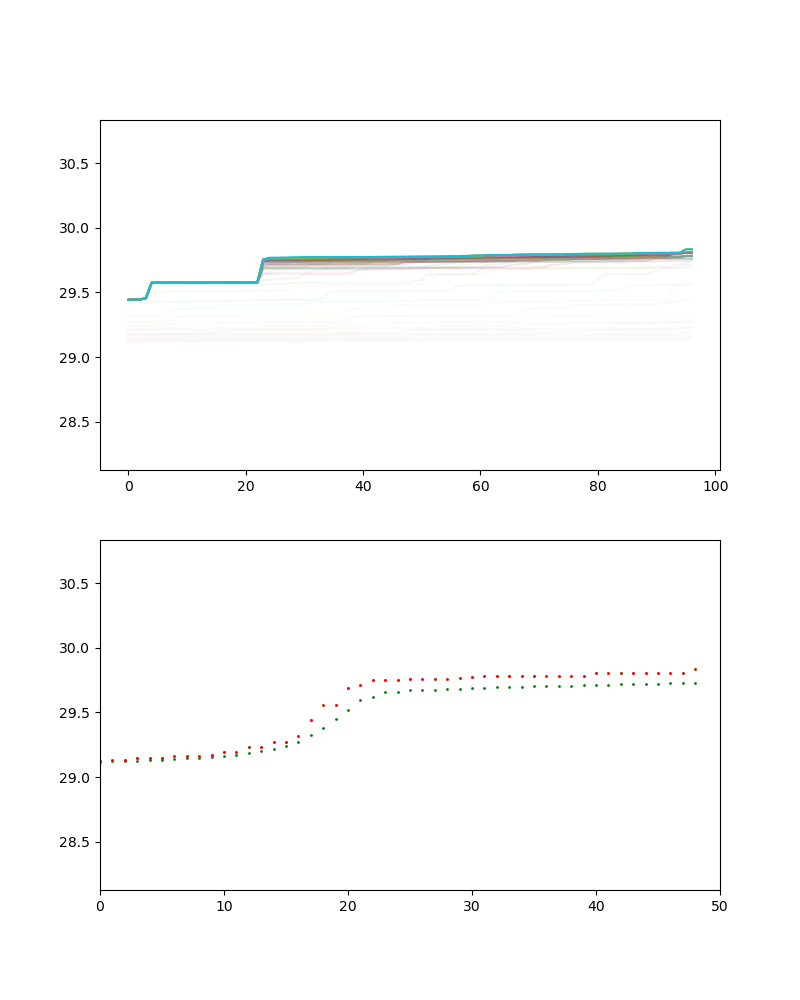

  Did updates over RECN: [30, 0, 0, 0] 29.127164749739528
  Did updates over RECN: [29, 1, 0, 0] 29.13498099218317
  Did updates over RECN: [30, 0, 0, 0] 29.13498099218317
  Did updates over RECN: [28, 2, 0, 0] 29.14679986717803
  Did updates over RECN: [30, 0, 0, 0] 29.14679986717803
  Did updates over RECN: [30, 0, 0, 0] 29.14679986717803
  Did updates over RECN: [26, 4, 0, 0] 29.161669090467345
  Did updates over RECN: [30, 0, 0, 0] 29.161669090467345
  Did updates over RECN: [30, 0, 0, 0] 29.161669090467345
  Did updates over RECN: [12, 18, 0, 0] 29.17220580842937
  Did updates over RECN: [27, 3, 0, 0] 29.192323944711372
  Did updates over RECN: [30, 0, 0, 0] 29.192323944711372
  Did updates over RECN: [11, 19, 0, 0] 29.23089341941327
  Did updates over RECN: [30, 0, 0, 0] 29.23089341941327
  Did updates over RECN: [16, 14, 0, 0] 29.27305089776401
  Did updates over RECN: [30, 0, 0, 0] 29.27305089776401
  Did updates over RECN: [1, 29, 0, 0] 29.320358710459672
  Did updates over RE


Got initial judgement
Initial range is -10343.99-25.95


<IPython.core.display.Javascript object>


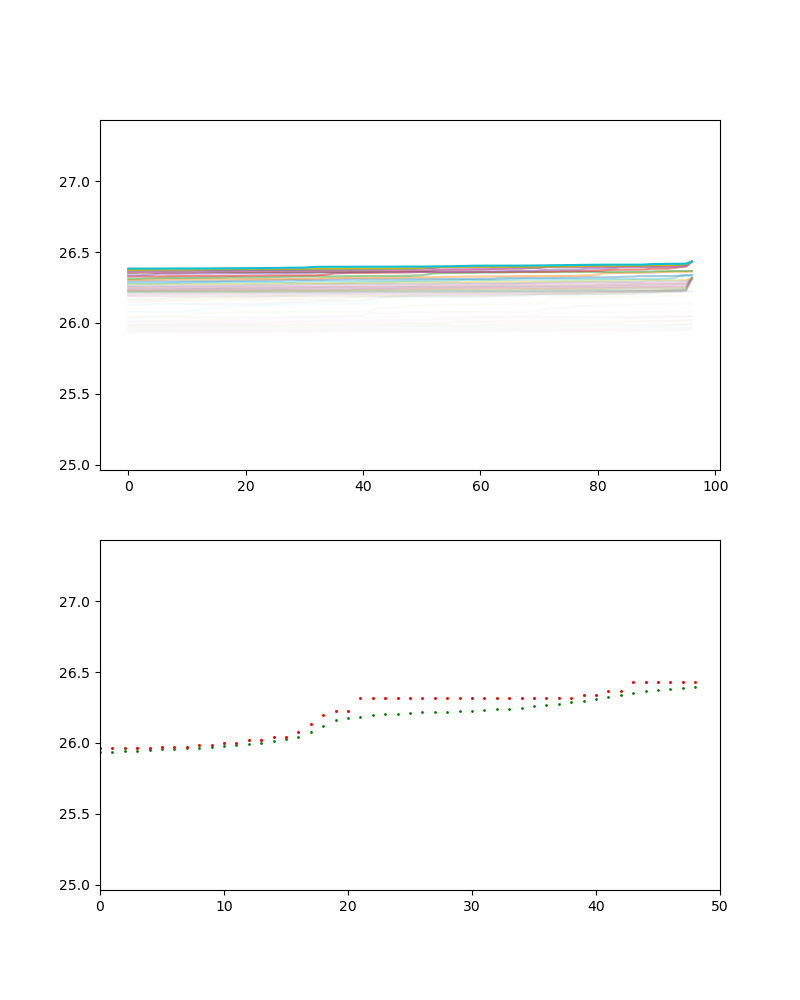

  Did updates over RECN: [29, 1, 0, 0] 25.961221091370906
  Did updates over RECN: [30, 0, 0, 0] 25.961221091370906
  Did updates over RECN: [30, 0, 0, 0] 25.961221091370906
  Did updates over RECN: [30, 0, 0, 0] 25.961221091370906
  Did updates over RECN: [30, 0, 0, 0] 25.961221091370906
  Did updates over RECN: [29, 1, 0, 0] 25.974173254827516
  Did updates over RECN: [30, 0, 0, 0] 25.974173254827516
  Did updates over RECN: [30, 0, 0, 0] 25.974173254827516
  Did updates over RECN: [25, 5, 0, 0] 25.986425679701654
  Did updates over RECN: [30, 0, 0, 0] 25.986425679701654
  Did updates over RECN: [29, 1, 0, 0] 25.99870610575189
  Did updates over RECN: [30, 0, 0, 0] 25.99870610575189
  Did updates over RECN: [18, 12, 0, 0] 26.02040241857084
  Did updates over RECN: [30, 0, 0, 0] 26.02040241857084
  Did updates over RECN: [16, 14, 0, 0] 26.0447911418477
  Did updates over RECN: [30, 0, 0, 0] 26.0447911418477
  Did updates over RECN: [4, 26, 0, 0] 26.0772904894808
  Did updates over REC


Got initial judgement
Initial range is 22.92-22.94


<IPython.core.display.Javascript object>


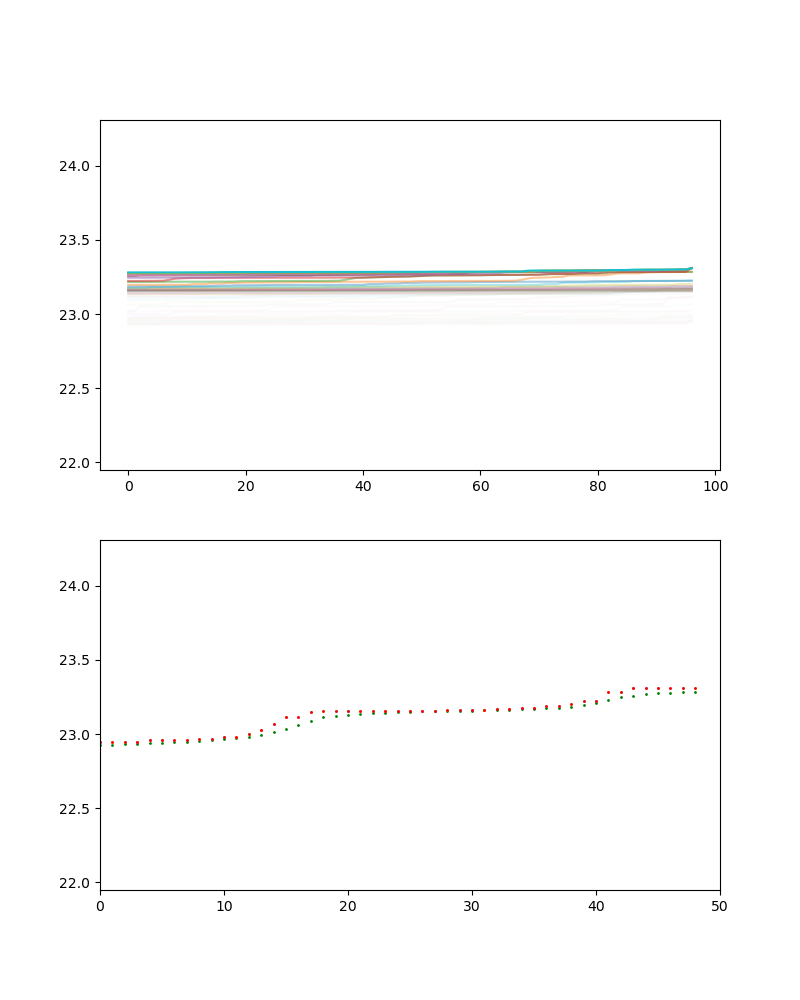

  Did updates over RECN: [29, 1, 0, 0] 22.946964941275308
  Did updates over RECN: [30, 0, 0, 0] 22.946964941275308
  Did updates over RECN: [30, 0, 0, 0] 22.946964941275308
  Did updates over RECN: [30, 0, 0, 0] 22.946964941275308
  Did updates over RECN: [29, 1, 0, 0] 22.958245915979525
  Did updates over RECN: [30, 0, 0, 0] 22.958245915979525
  Did updates over RECN: [30, 0, 0, 0] 22.958245915979525
  Did updates over RECN: [30, 0, 0, 0] 22.958245915979525
  Did updates over RECN: [23, 7, 0, 0] 22.969035244280732
  Did updates over RECN: [30, 0, 0, 0] 22.969035244280732
  Did updates over RECN: [24, 6, 0, 0] 22.982465972762437
  Did updates over RECN: [30, 0, 0, 0] 22.982465972762437
  Did updates over RECN: [8, 22, 0, 0] 22.997199377689864
  Did updates over RECN: [1, 29, 0, 0] 23.025547949757307
  Did updates over RECN: [17, 13, 0, 0] 23.066263806557785
  Did updates over RECN: [25, 5, 0, 0] 23.115721921559334
  Did updates over RECN: [29, 0, 1, 0] 23.115721921559334
  Did updates


Got initial judgement
Initial range is -2144.90-20.43


<IPython.core.display.Javascript object>


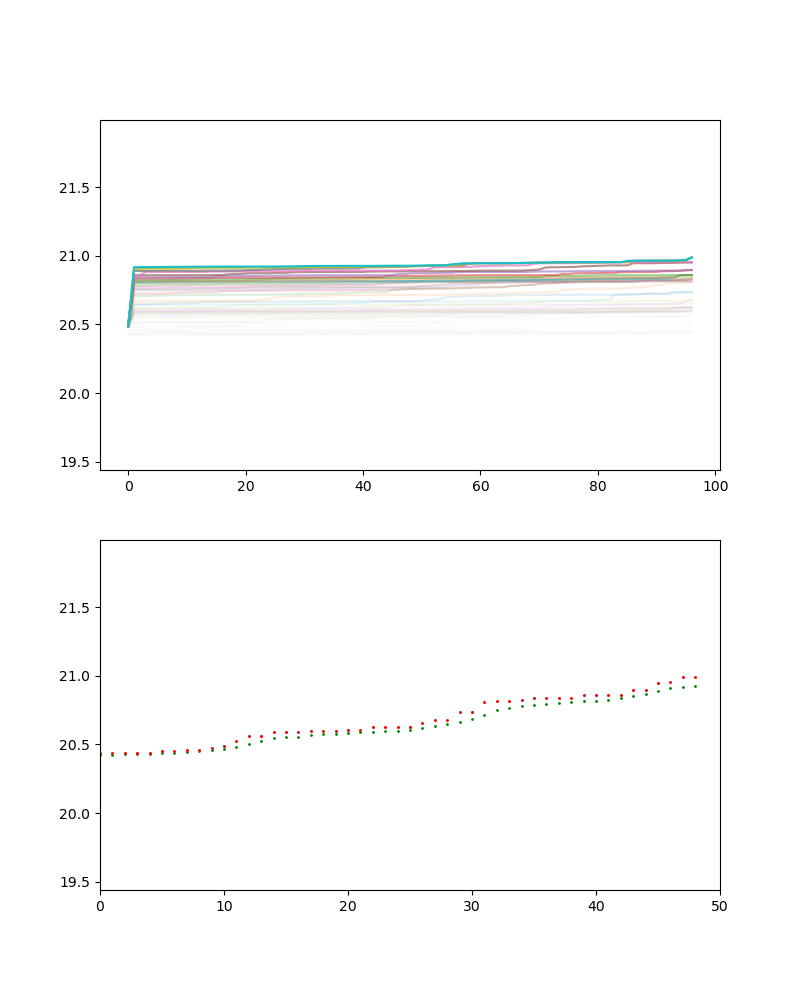

  Did updates over RECN: [29, 1, 0, 0] 20.44079055903005
  Did updates over RECN: [30, 0, 0, 0] 20.44079055903005
  Did updates over RECN: [30, 0, 0, 0] 20.44079055903005
  Did updates over RECN: [30, 0, 0, 0] 20.44079055903005
  Did updates over RECN: [30, 0, 0, 0] 20.44079055903005
  Did updates over RECN: [18, 12, 0, 0] 20.450934953729874
  Did updates over RECN: [30, 0, 0, 0] 20.450934953729874
  Did updates over RECN: [27, 3, 0, 0] 20.459239039518188
  Did updates over RECN: [30, 0, 0, 0] 20.459239039518188
  Did updates over RECN: [4, 26, 0, 0] 20.471997671965113
  Did updates over RECN: [3, 27, 0, 0] 20.489958894791748
  Did updates over RECN: [13, 17, 0, 0] 20.52363830998804
  Did updates over RECN: [19, 11, 0, 0] 20.559615203818108
  Did updates over RECN: [30, 0, 0, 0] 20.559615203818108
  Did updates over RECN: [24, 5, 0, 1] 20.589107470542814
  Did updates over RECN: [5, 0, 1, 24] 20.591098356064407
  Did updates over RECN: [6, 0, 3, 21] 20.594102881024778
  Did updates ove


Got initial judgement
Initial range is -207929.13--49400.16


<IPython.core.display.Javascript object>


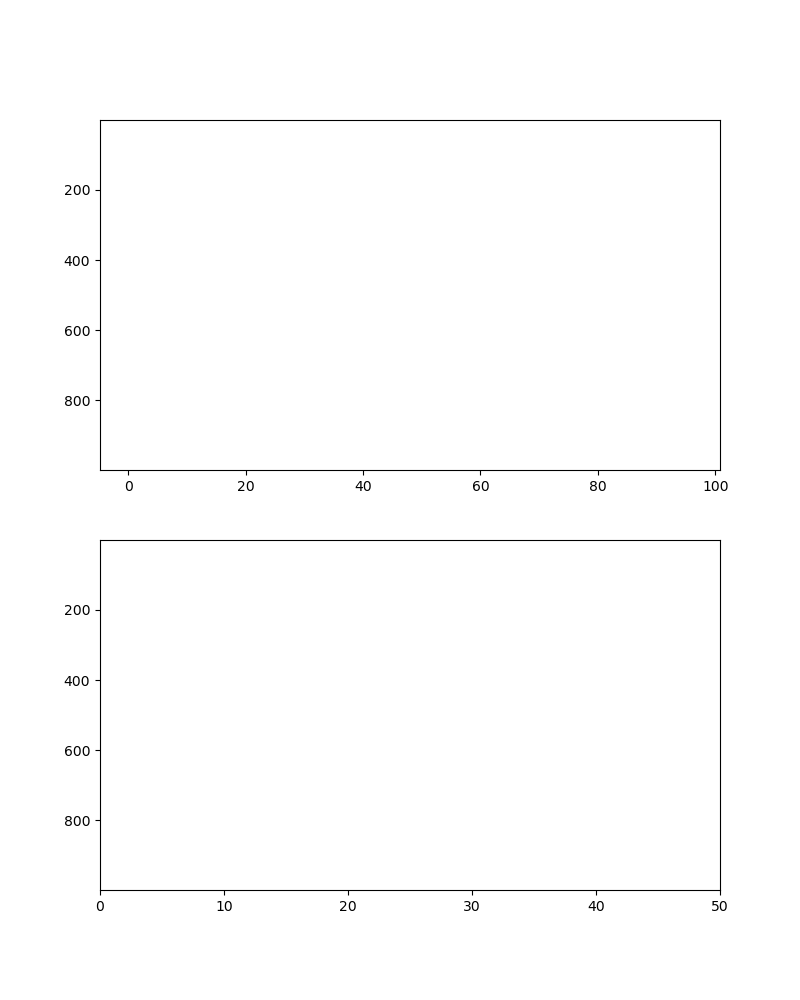

  Did updates over RECN: [29, 1, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [30, 0, 0, 0] -41437.052028933016
  Did updates over RECN: [0, 30, 0, 0] -39283.24110672163
  Did updates over RECN: [24, 6, 0, 0] -36644.70041264471
  Did updates over RECN: [30, 0, 0, 0] -36644.70041264471
  Did updates over RECN: [11, 19, 0, 0] -34114.67251032706



Got initial judgement
Initial range is -39983.87-16.12


<IPython.core.display.Javascript object>


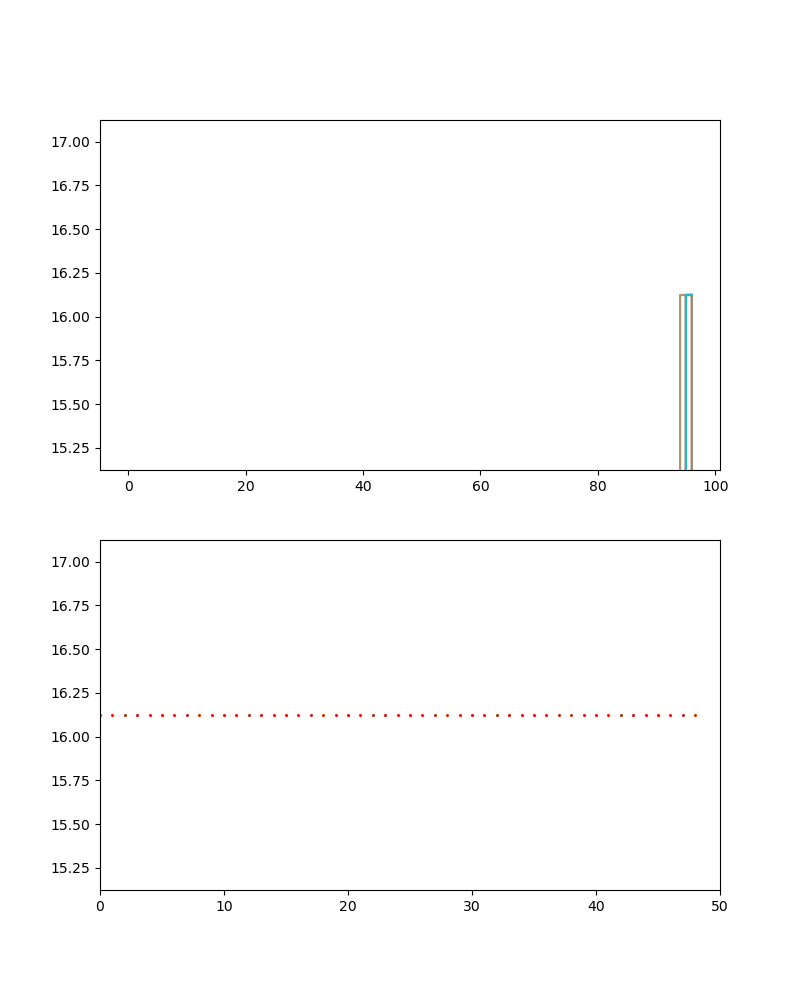

  Did updates over RECN: [29, 0, 0, 1] 16.123503468889375
  Did updates over RECN: [30, 0, 0, 0] 16.123503468889375
  Did updates over RECN: [29, 0, 1, 0] 16.123503468889375
  Did updates over RECN: [19, 0, 5, 6] 16.123503468889375
  Did updates over RECN: [26, 0, 1, 3] 16.123503468889375
  Did updates over RECN: [21, 0, 5, 4] 16.123503468889375
  Did updates over RECN: [11, 0, 0, 19] 16.123503468889375
  Did updates over RECN: [0, 0, 2, 28] 16.123503468889375
  Did updates over RECN: [0, 0, 1, 29] 16.123503468889375
SHRINK
from Vector<-1675.45,-3.49,6271.21,1.56,4.76 ... 0.12,7207.52,1.57,5.01,5.01> towards Vector<-1675.61,-3.66,6272.52,1.56,4.77 ... 0.4,7210.02,1.57,5.0,5.0>
to Vector<-1675.53,-3.58,6271.87,1.56,4.77 ... 0.26,7208.77,1.57,5.0,5.0>
and Vector<-1675.61,-3.66,6272.52,1.56,4.77 ... 0.4,7210.02,1.57,5.0,5.0>
  Did updates over RECN: [21, 0, 2, 7] 16.123503468889375
  Did updates over RECN: [26, 0, 2, 2] 16.123503468889375
  Did updates over RECN: [29, 0, 1, 0] 16.12350346


Got initial judgement
Initial range is -39985.38-14.62


<IPython.core.display.Javascript object>


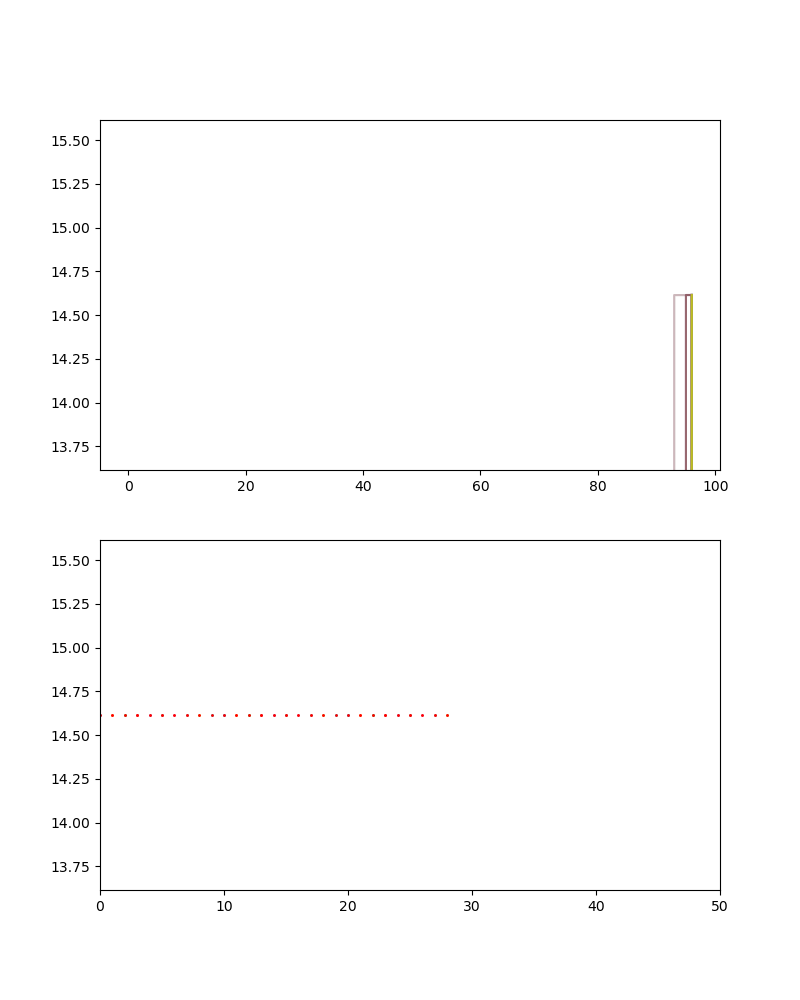

  Did updates over RECN: [30, 0, 0, 0] 14.615477857988044
  Did updates over RECN: [30, 0, 0, 0] 14.615477857988044
  Did updates over RECN: [30, 0, 0, 0] 14.615477857988044
  Did updates over RECN: [29, 0, 0, 1] 14.615477857988044
  Did updates over RECN: [30, 0, 0, 0] 14.615477857988044
  Did updates over RECN: [29, 0, 1, 0] 14.615477857988044
  Did updates over RECN: [3, 0, 1, 26] 14.615477857988044
  Did updates over RECN: [3, 0, 0, 27] 14.615477857988044
SHRINK
from Vector<-1810.31,0.14,7274.63,1.57,5.01 ... 0.14,8209.51,1.57,4.99,4.99> towards Vector<-1810.05,0.4,7272.52,1.57,5.0 ... 0.4,8210.02,1.57,5.0,5.0>
to Vector<-1810.18,0.27,7273.58,1.57,5.01 ... 0.27,8209.77,1.57,4.99,4.99>
and Vector<-1810.05,0.4,7272.52,1.57,5.0 ... 0.4,8210.02,1.57,5.0,5.0>
  Did updates over RECN: [27, 0, 0, 3] 14.615477857988044
  Did updates over RECN: [28, 0, 1, 1] 14.615477857988044
  Did updates over RECN: [29, 0, 0, 1] 14.615477857988044
  Did updates over RECN: [20, 0, 3, 7] 14.615477857988044

KeyboardInterrupt: 

In [5]:
# So like, 8AM to 8AM start at 50% battery and make up some budgets?
idle = 400
budgets = [
  # 0800 - 1100
  -100,
  -850,
  -1500,
  -2150,
  # 1200-1500
  # Well, the battery becomes fully charged in here so whatever
  -1250,
  -200,
  -200,
  0,
  # 1600-1900
  0, idle, idle, idle+100,
  # 2000-2300
  idle, idle, idle, idle,
  # 0000-0300
  idle, idle, idle, idle,
  # 0400-0700
  idle, idle, idle, idle
]

if sum(budgets) > 0:
  raise TypeError('Have a defecit of %.2f Wh, where we gonna get that?' % sum(budgets))
if len(budgets) != 24:
  raise TypeError('Not enough hours in the day (or too many?)')
  
print('optimizing over', len(budgets), sum(budgets), 'Wh')

data = []
start = pd.to_datetime('2020-11-28T08')
hr = pd.to_timedelta('1h')
bat = 0.5 * 15.5 * 650
waypoint = [0, 1800.1, 1000, 0, 5, 5]

for i in tqdm(range(24)):
  print('Doing start of', start, 'with budget of', budgets[i])
  stuff = optimizePiece(start, start + hr, bat, waypoint, budgets[i], mode='nm')
  start += hr
  
  data.append(stuff)
  vec, flight, score, waypoint, bat, stats = stuff
  batRange = stats['battery'][stats['battery'].index[0]], stats['battery'][stats['battery'].index[-1]]
  z = stats['poses'].z
  zRange = z.min(), z.max()
  zStart = z[z.index[0]]
  zEnd = z[z.index[-1]]
  grav = craft._mass * 9.8 * (zEnd - zStart) / 3600
  print('  Done and battery is %s->%.2f/%.2f and altitude is %s %.2f->%.2f and E_g delta is %.2f' %
        (batRange, batRange[1] - batRange[0], budgets[i], zRange, zStart, zEnd, grav)
   )
  